## Pix2Pix paper implementation
This is an implementation of Pix2Pix [paper](https://drive.google.com/file/d/1BEPkay77ZCu7QPXRloUZUVWrwKlvEfgm/view?usp=sharing), which talks about the concept of trainig the model from scratch to learn Loss function, essentially converting pictures from one form to another.
This saves the difficulty of constructing difficult loss functions and making the task of finding loss function that of the GAN. Due to this, we'll use a conditional GAN, which will allow us to input both input image and target image, essentially allowing us to make a generator for image we input, and not random images from noise.

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import albumentations as A
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.chdir('/content/drive/MyDrive/Pix2Pix')

In [4]:
!ls

1611.07004.pdf	 discFAC.pth.tar  facades	genCOM.pth.tar	Pix2Pix.ipynb
discCOM.pth.tar  evaluation	  facetocomics	genFAC.pth.tar


In [5]:
both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.Resize(width=286, height=286),
        A.ColorJitter(p=0.2),
        A.RandomCrop(width=256, height=256),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [6]:
class MultiDataset(Dataset):
    def __init__(self, root_dir, split=False, targetOnLeft=False):
        super().__init__()
        self.root_dir = root_dir
        self.split = split
        self.targetOnLeft = targetOnLeft
        self.list_files = os.listdir(self.root_dir)
        # print(self.list_files)

    def __len__(self):
        if self.split:
            sub_dir = os.path.join(self.root_dir, self.list_files[0])
            return len(os.listdir(sub_dir))
        else:
            return len(self.list_files)

    def __getitem__(self, index):
        if self.split == False:
            img_file = self.list_files[index]
            img_path = os.path.join(self.root_dir, img_file)
            image = np.array(Image.open(img_path))
            if self.targetOnLeft:
                input_image = image[:, 256:, :]
                target_image = image[:, :256, :]
            else:
                input_image = image[:, :256, :]
                target_image = image[:, 256:, :]
        else:
            output_dir = os.path.join(self.root_dir, self.list_files[0])
            input_dir = os.path.join(self.root_dir, self.list_files[1])
            output_img_file = os.listdir(output_dir)[index]
            input_img_file = os.listdir(input_dir)[index]
            output_img_path = os.path.join(output_dir, output_img_file)
            input_img_path = os.path.join(input_dir, input_img_file)
            # print(output_img_path, input_img_path)
            target_image = np.array(Image.open(output_img_path))
            input_image = np.array(Image.open(input_img_path))

        # Apply data augmentations to input and target images
        augmentations = both_transform(image=input_image, image0=target_image)
        input_image, target_image = augmentations["image"], augmentations["image0"]
        input_image = transform_only_input(image=input_image)['image']
        target_image = transform_only_mask(image=target_image)['image']
        return input_image, target_image


In [33]:
!rmdir '/content/facetocomics/.ipynb_checkpoints'

In [8]:
dataset = MultiDataset('/content/drive/MyDrive/Pix2Pix/facetocomics', split=True)
print(len(dataset))
print(dataset.__getitem__(1)[0].shape)
dataset = MultiDataset('/content/drive/MyDrive/Pix2Pix/facades/train', targetOnLeft=True)
print(len(dataset))
print(dataset.__getitem__(1)[0].shape)

10000
torch.Size([3, 256, 256])
400
torch.Size([3, 256, 256])


### Defining the Models

In [9]:
#Let's make Discriminator: C64-C128-C256-C512
# This is a patchGAN
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            #C64
            nn.Conv2d(in_channels*2, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            #C128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #C256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            #C512
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'),
        )

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        return self.model(x)

x= torch.randn((1, 3, 256, 256))
y = torch.randn((1, 3, 256, 256))
model = Discriminator()
preds = model(x, y)
print(preds.shape)
print(model)

torch.Size([1, 1, 30, 30])
Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padd

In [12]:
# Let's make Generator
# It's Encoder is of the form: C64-C128-C256-C512-C512-C512-C512-C512
# It's Decoder is of the form: CD512-CD512-CD512-C512-C256-C128-C64
# where CD is covolutional with a dropout of 50%
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect')
                if down
                else
                    nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        )

        self.down1 = Block(features, features*2, down=True, act='Leaky', use_dropout=False)
        self.down2 = Block(features*2, features*4, down=True, act='Leaky', use_dropout=False)
        self.down3 = Block(features*4, features*8, down=True, act='Leaky', use_dropout=False)
        self.down4 = Block(features*8, features*8, down=True, act='Leaky', use_dropout=False)
        self.down5 = Block(features*8, features*8, down=True, act='Leaky', use_dropout=False)
        self.down6 = Block(features*8, features*8, down=True, act='Leaky', use_dropout=False)
        self.bottle_neck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode='reflect'),
            nn.ReLU(),
        )
        self.up1 = Block(features*8, features*8, down=False, act='relu', use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act='relu', use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act='relu', use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act='relu', use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, 4, 2, 1),
            nn.Tanh(),
        )
        for m in self.modules():
            if isinstance(m, Block):
                m.apply(weights_init)

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottle_neck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], dim=1))
        up3 = self.up3(torch.cat([up2, d6], dim=1))
        up4 = self.up4(torch.cat([up3, d5], dim=1))
        up5 = self.up5(torch.cat([up4, d4], dim=1))
        up6 = self.up6(torch.cat([up5, d3], dim=1))
        up7 = self.up7(torch.cat([up6, d2], dim=1))
        return self.final_up(torch.cat([up7, d1], 1))

x = torch.randn((1, 3, 256, 256))
model = Generator(3, 64)
preds = model(x)
print(preds.shape)
print(model)

torch.Size([1, 3, 256, 256])
Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), p

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)
## For initializing the weights

Now that we have finally defined Discriminator and Generator, it is time to move to Training the model. First we will set up some HyperParameters.
### Training Facades Dataset

In [17]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/content/drive/MyDrive/Pix2Pix/facades/train"
VAL_DIR = "/content/drive/MyDrive/Pix2Pix/facades/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 1
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
NUM_EPOCHS = 500
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_DISC = "/content/drive/MyDrive/Pix2Pix/discFAC.pth.tar"
CHECKPOINT_GEN = "/content/drive/MyDrive/Pix2Pix/genFAC.pth.tar"

In [13]:
# Some utilities for saving examples and model
def save_some_examples(gen, val_loader, epoch, folder='/content/drive/MyDrive/Pix2Pix/facades_eval'):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

Now we have set up Hyperparameters according to the paper and some functions to regularly save our model.

In [14]:
def train_m(disc, gen, loader, opt_disc, opt_gen, l1, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

In [ ]:
disc = Discriminator().to(DEVICE)
disc.apply(weights_init)
gen = Generator().to(DEVICE)
gen.apply(weights_init)
opt_disc = optim.Adam(disc.parameters(),lr = LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(),lr = LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

train_dataset = MultiDataset(root_dir='/content/drive/MyDrive/Pix2Pix/facades/train', targetOnLeft=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataset = MultiDataset(root_dir='/content/drive/MyDrive/Pix2Pix/facades/val', targetOnLeft=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
# else:
    # writer = SummaryWriter("evaluation/gen/")
    # x, _ = train_dataset.__getitem__(0)
    # writer.add_graph(gen,x)
    # writer.close()
    # writer = SummaryWriter("evaluation/disc/")
    # x, y = train_dataset.__getitem__(0)
    # writer.add_graph(disc,(x, y))
    # writer.close()

for epoch in range(NUM_EPOCHS):
    train_m(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

    if SAVE_MODEL and epoch%5==0:
        save_checkpoint(gen, opt_gen, CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, CHECKPOINT_DISC)

    save_some_examples(gen, val_loader, epoch, folder='/content/drive/MyDrive/Pix2Pix/evaluation/facade')


100%|██████████| 400/400 [00:22<00:00, 17.74it/s, D_fake=0.105, D_real=0.869]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.35it/s, D_fake=0.169, D_real=0.454]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.52it/s, D_fake=0.0999, D_real=0.937]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:23<00:00, 17.04it/s, D_fake=0.129, D_real=0.966]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.25it/s, D_fake=0.477, D_real=0.319]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 18.04it/s, D_fake=0.144, D_real=0.282]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.98it/s, D_fake=0.177, D_real=0.634]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.58it/s, D_fake=0.0602, D_real=0.971]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.44it/s, D_fake=0.203, D_real=0.78]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.90it/s, D_fake=0.0505, D_real=0.911]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.28it/s, D_fake=0.437, D_real=0.33]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.52it/s, D_fake=0.0654, D_real=0.884]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 18.09it/s, D_fake=0.281, D_real=0.395]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.39it/s, D_fake=0.18, D_real=0.707]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.42it/s, D_fake=0.373, D_real=0.665]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.43it/s, D_fake=0.146, D_real=0.905]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.33it/s, D_fake=0.207, D_real=0.915]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.54it/s, D_fake=0.276, D_real=0.667]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.80it/s, D_fake=0.383, D_real=0.383]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.56it/s, D_fake=0.177, D_real=0.675]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.50it/s, D_fake=0.535, D_real=0.45]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.23it/s, D_fake=0.18, D_real=0.848]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.22it/s, D_fake=0.326, D_real=0.687]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.43it/s, D_fake=0.213, D_real=0.601]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.71it/s, D_fake=0.35, D_real=0.682]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.59it/s, D_fake=0.2, D_real=0.75]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.62it/s, D_fake=0.272, D_real=0.675]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 18.00it/s, D_fake=0.148, D_real=0.832]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.21it/s, D_fake=0.183, D_real=0.833]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.38it/s, D_fake=0.643, D_real=0.202]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.56it/s, D_fake=0.357, D_real=0.52]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.31it/s, D_fake=0.183, D_real=0.733]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.25it/s, D_fake=0.188, D_real=0.814]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.32it/s, D_fake=0.131, D_real=0.879]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.67it/s, D_fake=0.0929, D_real=0.94]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.57it/s, D_fake=0.134, D_real=0.786]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.54it/s, D_fake=0.465, D_real=0.547]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.62it/s, D_fake=0.146, D_real=0.81]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.71it/s, D_fake=0.268, D_real=0.712]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.66it/s, D_fake=0.263, D_real=0.682]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.68it/s, D_fake=0.226, D_real=0.716]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:23<00:00, 17.32it/s, D_fake=0.367, D_real=0.709]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.21it/s, D_fake=0.206, D_real=0.845]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.93it/s, D_fake=0.346, D_real=0.617]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.81it/s, D_fake=0.257, D_real=0.616]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:23<00:00, 17.37it/s, D_fake=0.353, D_real=0.459]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.29it/s, D_fake=0.199, D_real=0.742]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 18.13it/s, D_fake=0.251, D_real=0.696]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.99it/s, D_fake=0.186, D_real=0.805]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.96it/s, D_fake=0.35, D_real=0.571]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.42it/s, D_fake=0.425, D_real=0.518]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.41it/s, D_fake=0.256, D_real=0.609]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.63it/s, D_fake=0.301, D_real=0.595]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 18.18it/s, D_fake=0.354, D_real=0.504]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.43it/s, D_fake=0.38, D_real=0.652]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.27it/s, D_fake=0.12, D_real=0.893]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.60it/s, D_fake=0.275, D_real=0.596]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.23it/s, D_fake=0.221, D_real=0.737]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.60it/s, D_fake=0.283, D_real=0.691]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.45it/s, D_fake=0.212, D_real=0.755]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.26it/s, D_fake=0.287, D_real=0.703]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.60it/s, D_fake=0.295, D_real=0.666]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.38it/s, D_fake=0.269, D_real=0.677]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.91it/s, D_fake=0.231, D_real=0.715]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 18.08it/s, D_fake=0.14, D_real=0.875]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.49it/s, D_fake=0.245, D_real=0.733]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 18.13it/s, D_fake=0.197, D_real=0.836]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.76it/s, D_fake=0.152, D_real=0.782]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.61it/s, D_fake=0.174, D_real=0.758]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.35it/s, D_fake=0.354, D_real=0.875]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:21<00:00, 18.32it/s, D_fake=0.185, D_real=0.784]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 400/400 [00:22<00:00, 17.43it/s, D_fake=0.393, D_real=0.496]


=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/400 [00:00<?, ?it/s]

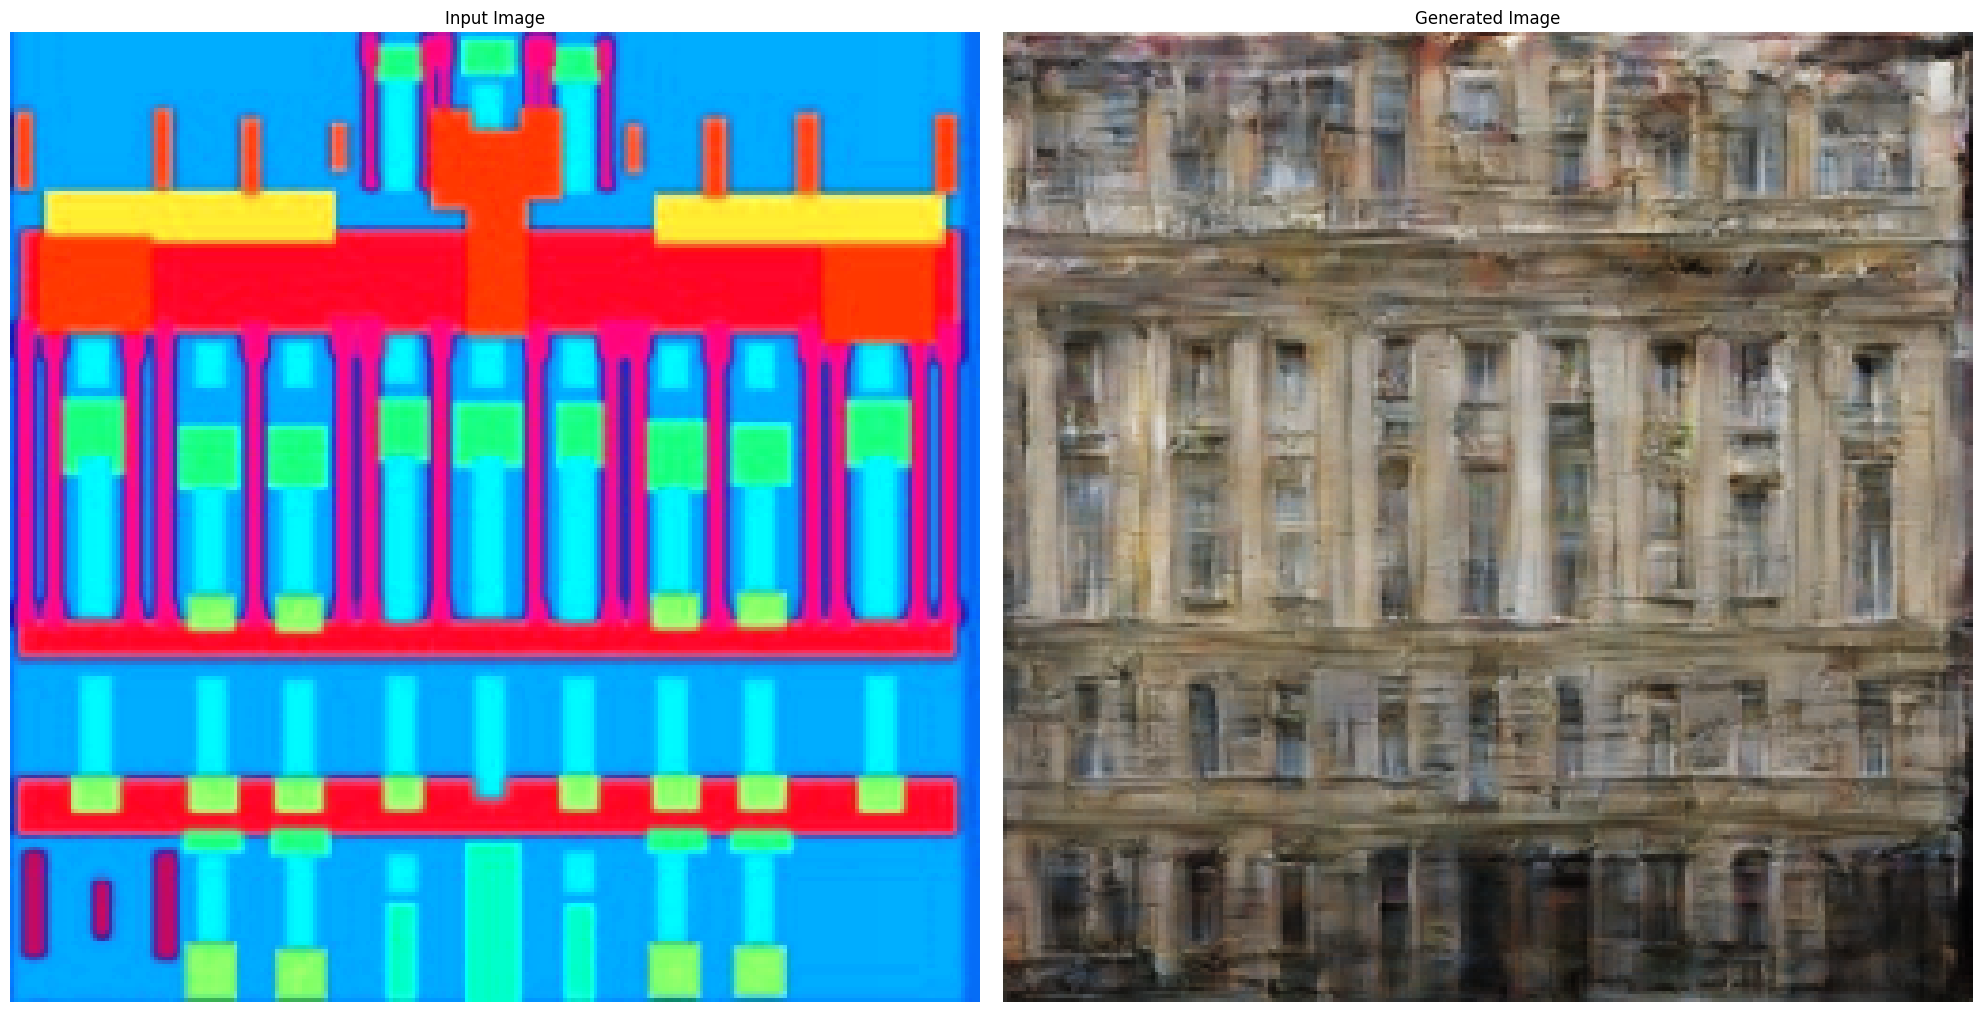

In [ ]:
img1 = plt.imread('/content/drive/MyDrive/Pix2Pix/evaluation/facade/input_394.png')
img2 = plt.imread('/content/drive/MyDrive/Pix2Pix/evaluation/facade/y_gen_394.png')
plt.figure(figsize=(20, 10))
# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')  # Turn off axis to remove ticks and labels
plt.title('Input Image')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')  # Turn off axis to remove ticks and labels
plt.title('Generated Image')

# Explicitly remove overlapping axes
plt.tight_layout()
plt.show()

In [18]:
disc = Discriminator()
disc.apply(weights_init)
gen = Generator()
gen.apply(weights_init)
opt_disc = optim.Adam(disc.parameters(),lr = LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(),lr = LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

train_dataset = MultiDataset(root_dir='/content/drive/MyDrive/Pix2Pix/facades/train', targetOnLeft=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataset = MultiDataset(root_dir='/content/drive/MyDrive/Pix2Pix/facades/test', targetOnLeft=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)

gen.eval()
x, y = next(iter(test_loader))
with torch.no_grad():
    y_fake = gen(x)
    x = x*0.5+0.5
    y = y*0.5+0.5
    y_fake = y_fake*0.5+0.5
x.shape, x[0]

=> Loading checkpoint
=> Loading checkpoint


(torch.Size([1, 3, 256, 256]),
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.1882, 0.1882, 0.1882],
          [0.0000, 0.0000, 0.0000,  ..., 0.1882, 0.1882, 0.1882],
          [0.0000, 0.0000, 0.0000,  ..., 0.1882, 0.1882, 0.1882],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.8706, 0.8706, 0.8706,  ..., 1.0000, 1.0000, 1.0000],
          [0.8706, 0.8706, 0.8706,  ..., 1.0000, 1.0000, 1.0000],
         

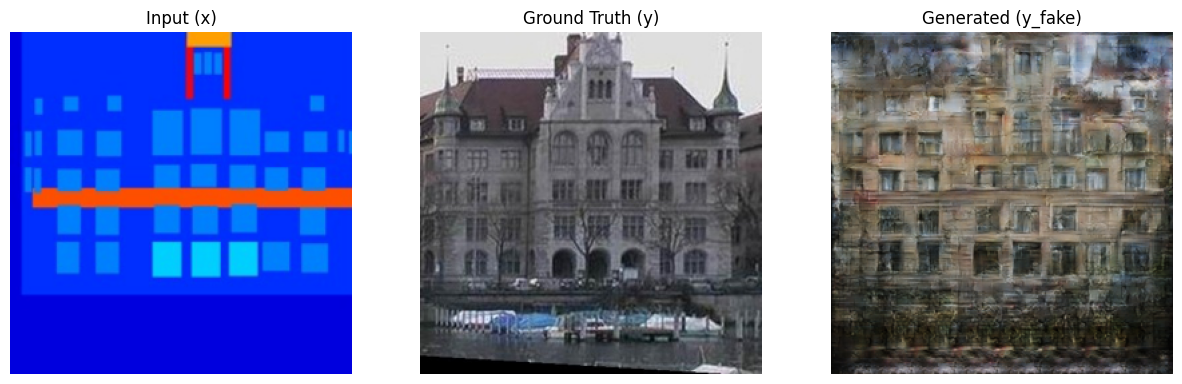

In [19]:
x_np = x.squeeze(0).cpu().numpy()
y_np = y.squeeze(0).cpu().numpy()
y_fake_np = y_fake.squeeze(0).cpu().numpy()

# Convert images from [0, 1] range to [0, 255] range
x_np = (x_np * 255).astype(int)
y_np = (y_np * 255).astype(int)
y_fake_np = (y_fake_np * 255).astype(int)

# Create a single figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display x
axes[0].imshow(x_np.transpose(1, 2, 0))
axes[0].set_title('Input (x)')
axes[0].axis('off')

# Display y
axes[1].imshow(y_np.transpose(1, 2, 0))
axes[1].set_title('Ground Truth (y)')
axes[1].axis('off')

# Display y_fake
axes[2].imshow(y_fake_np.transpose(1, 2, 0))
axes[2].set_title('Generated (y_fake)')
axes[2].axis('off')

# Show the plot
plt.show()

As we can see, the generated image is not exceptional even after 400 epochs, and some improvement is required. We'll now improve our Generator and Discriminator and train it on Face to Comic dataset to analyze the improvement.

In terms of improvement, we will simply replace BatchNorm with InstanceNorm, which will possibly reduce artifacts, add a RandomCrop to resize the image in translation, increase batch size to 4(any larger than this takes too long), and decrease epochs to 100.
### Improvement testing

In [20]:
#Let's make Discriminator: C64-C128-C256-C512
# This is a patchGAN
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            #C64
            nn.Conv2d(in_channels*2, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            #C128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False, padding_mode='reflect'),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2),
            #C256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False, padding_mode='reflect'),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2),
            #C512
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'),
        )

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        return self.model(x)

x= torch.randn((1, 3, 256, 256))
y = torch.randn((1, 3, 256, 256))
model = Discriminator()
preds = model(x, y)
print(preds.shape)
print(model)

torch.Size([1, 1, 30, 30])
Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('InstanceNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)
## For initializing the weights

In [22]:
# Let's make Generator
# It's Encoder is of the form: C64-C128-C256-C512-C512-C512-C512-C512
# It's Decoder is of the form: CD512-CD512-CD512-C512-C256-C128-C64
# where CD is covolutional with a dropout of 50%
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect')
                if down
                else
                    nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        )

        self.down1 = Block(features, features*2, down=True, act='Leaky', use_dropout=False)
        self.down2 = Block(features*2, features*4, down=True, act='Leaky', use_dropout=False)
        self.down3 = Block(features*4, features*8, down=True, act='Leaky', use_dropout=False)
        self.down4 = Block(features*8, features*8, down=True, act='Leaky', use_dropout=False)
        self.down5 = Block(features*8, features*8, down=True, act='Leaky', use_dropout=False)
        self.down6 = Block(features*8, features*8, down=True, act='Leaky', use_dropout=False)
        self.bottle_neck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode='reflect'),
            nn.ReLU(),
        )
        self.up1 = Block(features*8, features*8, down=False, act='relu', use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act='relu', use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act='relu', use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act='relu', use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, 4, 2, 1),
            nn.Tanh(),
        )
        # for m in self.modules():
        #     if isinstance(m, Block):
        #         m.apply(weights_init)

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottle_neck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], dim=1))
        up3 = self.up3(torch.cat([up2, d6], dim=1))
        up4 = self.up4(torch.cat([up3, d5], dim=1))
        up5 = self.up5(torch.cat([up4, d4], dim=1))
        up6 = self.up6(torch.cat([up5, d3], dim=1))
        up7 = self.up7(torch.cat([up6, d2], dim=1))
        return self.final_up(torch.cat([up7, d1], 1))

x = torch.randn((1, 3, 256, 256))
model = Generator(3, 64)
preds = model(x)
print(preds.shape)
print(model)

torch.Size([1, 3, 256, 256])
Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(

In [18]:
## Importing dataset to colab local to increase speed
import shutil
for i in range(10000):
    shutil.copy(f'/content/drive/MyDrive/Pix2Pix/facetocomics/comics/{i}.jpg', f'/content/facetocomics/comics/{i}.jpg')
    shutil.copy(f'/content/drive/MyDrive/Pix2Pix/facetocomics/face/{i}.jpg', f'/content/facetocomics/face/{i}.jpg')
    if i%1000==0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [23]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/content/drive/MyDrive/Pix2Pix/facetocomics/"
LEARNING_RATE = 2e-4
BATCH_SIZE = 1
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
NUM_EPOCHS = 100
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_DISC = "/content/drive/MyDrive/Pix2Pix/discCOM.pth.tar"
CHECKPOINT_GEN = "/content/drive/MyDrive/Pix2Pix/genCOM.pth.tar"

Now we will do similar training for comic dataset

In [ ]:
disc = Discriminator().to(DEVICE)
disc.apply(weights_init)
gen = Generator().to(DEVICE)
gen.apply(weights_init)
opt_disc = optim.Adam(disc.parameters(),lr = LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(),lr = LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

train_dataset = MultiDataset(root_dir=TRAIN_DIR, split=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataset = MultiDataset(root_dir='/content/drive/MyDrive/Pix2Pix/facetocomics/val', split=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
# else:
    # writer = SummaryWriter("evaluation/gen/")
    # x, _ = train_dataset.__getitem__(0)
    # writer.add_graph(gen,x)
    # writer.close()
    # writer = SummaryWriter("evaluation/disc/")
    # x, y = train_dataset.__getitem__(0)
    # writer.add_graph(disc,(x, y))
    # writer.close()

for epoch in range(11, NUM_EPOCHS):
    train_m(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

    if SAVE_MODEL and epoch%5==0:
        save_checkpoint(gen, opt_gen, CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, CHECKPOINT_DISC)

    save_some_examples(gen, val_loader, epoch, folder='/content/drive/MyDrive/Pix2Pix/evaluation/comic')


=> Loading checkpoint
=> Loading checkpoint


100%|██████████| 10000/10000 [11:04<00:00, 15.05it/s, D_fake=0.0577, D_real=0.82]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 10000/10000 [11:26<00:00, 14.58it/s, D_fake=0.0859, D_real=0.818]


=> Saving checkpoint
=> Saving checkpoint


 65%|██████▍   | 6499/10000 [07:23<04:52, 11.96it/s, D_fake=0.0332, D_real=0.629]

After 30 epochs, we have obtained a result which resembles human faces, but not the best it could have possibly been.

In [24]:
disc = Discriminator()
disc.apply(weights_init)
gen = Generator()
gen.apply(weights_init)
opt_disc = optim.Adam(disc.parameters(),lr = LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(),lr = LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

train_dataset = MultiDataset(root_dir=TRAIN_DIR, split=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataset = MultiDataset(root_dir='/content/drive/MyDrive/Pix2Pix/facetocomics/val', split=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)

gen.eval()
x, y = next(iter(test_loader))
with torch.no_grad():
    y_fake = gen(x)
    x = x*0.5+0.5
    y = y*0.5+0.5
    y_fake = y_fake*0.5+0.5

=> Loading checkpoint
=> Loading checkpoint


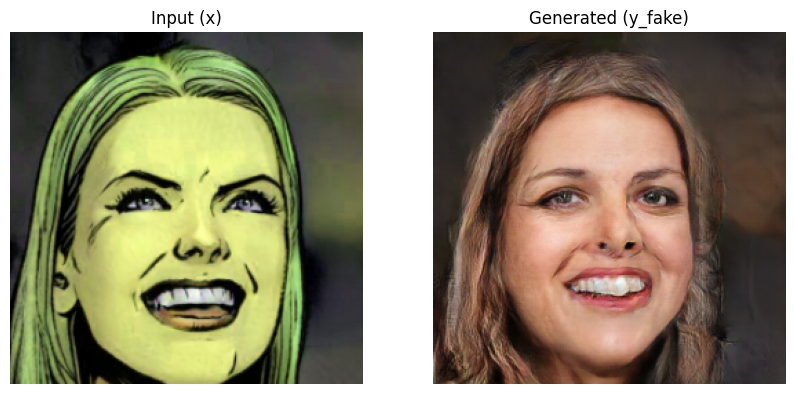

In [43]:
gen.eval()
x, y = next(iter(train_loader))
with torch.no_grad():
    y_fake = gen(x)
    x = x*0.5+0.5
    y = y*0.5+0.5
    y_fake = y_fake*0.5+0.5
x_np = x.squeeze(0).cpu().numpy()
y_np = y.squeeze(0).cpu().numpy()
y_fake_np = y_fake.squeeze(0).cpu().numpy()

# Convert images from [0, 1] range to [0, 255] range
x_np = (x_np * 255).astype(int)
y_np = (y_np * 255).astype(int)
y_fake_np = (y_fake_np * 255).astype(int)

# Create a single figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display x
axes[0].imshow(x_np.transpose(1, 2, 0))
axes[0].set_title('Input (x)')
axes[0].axis('off')

# Display y
# axes[1].imshow(y_np.transpose(1, 2, 0))
# axes[1].set_title('Ground Truth (y)')
# axes[1].axis('off')

# Display y_fake
axes[1].imshow(y_fake_np.transpose(1, 2, 0))
axes[1].set_title('Generated (y_fake)')
axes[1].axis('off')

# Show the plot
plt.show()

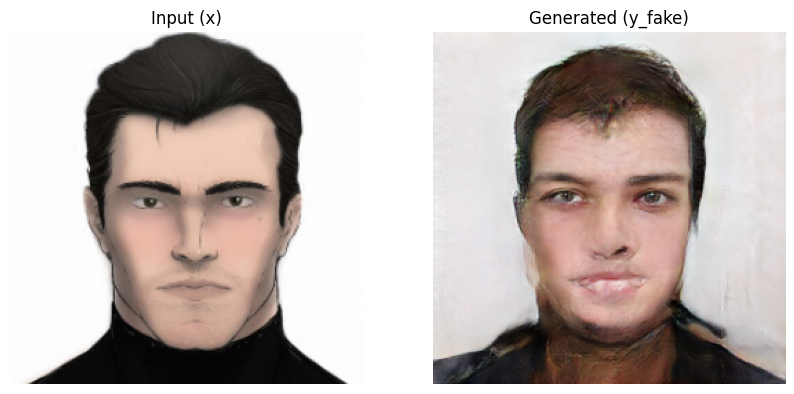

In [56]:
gen.eval()
x, y = next(iter(test_loader))
with torch.no_grad():
    y_fake = gen(x)
    x = x*0.5+0.5
    y = y*0.5+0.5
    y_fake = y_fake*0.5+0.5
x_np = x.squeeze(0).cpu().numpy()
y_np = y.squeeze(0).cpu().numpy()
y_fake_np = y_fake.squeeze(0).cpu().numpy()

# Convert images from [0, 1] range to [0, 255] range
x_np = (x_np * 255).astype(int)
y_np = (y_np * 255).astype(int)
y_fake_np = (y_fake_np * 255).astype(int)

# Create a single figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display x
axes[0].imshow(x_np.transpose(1, 2, 0))
axes[0].set_title('Input (x)')
axes[0].axis('off')

# Display y
# axes[1].imshow(y_np.transpose(1, 2, 0))
# axes[1].set_title('Ground Truth (y)')
# axes[1].axis('off')

# Display y_fake
axes[1].imshow(y_fake_np.transpose(1, 2, 0))
axes[1].set_title('Generated (y_fake)')
axes[1].axis('off')

# Show the plot
plt.show()